# Parameter Definition for LiteLoc Model
This guide explains how to define your own parameters for the LiteLoc Model for training and inference on your device. We provide demo dataset (available online) together with the default parameters saved in the **.yaml** file. 

## Training
The parameters for training will be used for model initialization which contain three categories, camera settings, point spread function (PSF) definition and training configuration. These parameters will determinate the simulated dataset used for training your models. As the LiteLoc model is dataset sensitive, the types of simulated images will fundementally impact the performance of the defined model.

In [1]:
import os
from utils.gui_utils import *
from utils.help_utils import *

main_directory = os.getcwd()
params_dict = {}

### Input Training Parameters
1. Camera settings

In [2]:
params_dict['Camera'] = Camera_GUI()

2. PSF definition

In [3]:
params_dict['PSF_model'] = PSF_GUI()

3. Training configuration

In [4]:
params_dict['Training'] = Training_GUI()

### Training Parameter Packaging 
All saved parameters for subsequent training will be converted to **types.SimpleNamespace** format for consistent access and management. These parameters can be saved and reloaded for future use.
1. Presenting and Transferring Parameter Data:

In [5]:
print(show_confirming_string(params_dict))

params = dict_to_namespace(params_dict)

--Camera :
camera : sCMOS
em_gain : 1.0
surp_p : 0.5
qe : 0.95
spurious_c : 0.002
sig_read : 1.535
e_per_adu : 0.7471
baseline : 100.0
--PSF_model :
z_scale : 700.0
simulate_method : spline
--spline_psf :
calibration_file : None
psf_extent : [[-0.5, 63.5], [-0.5, 63.5], None]
device_simulation : cuda
--vector_psf :
objstage0 : -500.0
zemit0 : None
zernikefit_file : None
pixelSizeX : 110
pixelSizeY : 110
psfSizeX : 51
NA : 1.5
wavelength : 680.0
refmed : 1.406
refcov : 1.524
refimm : 1.518
zernikefit_map : None
psfrescale : 0.5
Npupil : 64
--Training :
max_epoch : 50
eval_iteration : 500
batch_size : 16
valid_frame_num : 100
em_per_frame : 10
train_size : [64, 64]
photon_range : [4000, 40000]
result_path : None
infer_data : None
bg : None
perline_noise : True
pn_factor : 0.2
pn_res : 64
factor : None
offset : None
model_init : None
project_path : E:\Torch\LiteLoc_0401
project_name : LiteLoc-main



2. Saving Parameters:

In [6]:
yaml_file_folder = select_path('folder')

print("Please enter the file name：")
file_name = input()
if file_name[-5:] != '.yaml': 
    file_name += '.yaml'
    
yaml_file_path = os.path.join(yaml_file_folder, file_name)
save_yaml(params, yaml_file_path)

print("File saved as : {}".format(yaml_file_path))

Please enter the file name：


 0407test


File saved as : E:/Torch/LiteLoc_0401\0407test.yaml


## Pre-training Test
Before training your LiteLoc model, pre-training tests are provided to help users to exam defined point spread functions and view the simulated image. The pre-training tests are also involved in scripts when you excute training process.

### Viewing the Point Spread Function
You can examine the PSF before training the LiteLoc model. The PSF is represented in three dimensions and displayed as a 21-channel 2D image stack.

File selected :  E:/Torch/LiteLoc_0401/demo/demo1_astig_npc/train_params_demo1.yaml
--Camera :
camera : sCMOS
em_gain : 1.0
surv_p : 0.5
qe : 0.95
spurious_c : 0.002
sig_read : 1.535
e_per_adu : 0.7471
baseline : 100.0
--PSF_model :
z_scale : 700
simulate_method : vector
--spline_psf :
calibration_file : ../../calibrate_mat/Astigmatism_Tetraspeck_beads_2um_50nm_256_1_MMStack_Pos0.ome_3dcal.mat
psf_extent : [[-0.5, 63.5], [-0.5, 63.5], 'None']
device_simulation : cuda
--vector_psf :
objstage0 : -500
zernikefit_file : ../../beads_file/Astigmatism_Tetraspeck_beads_2um_50nm_256_1_MMStack_Pos0_calib_results.mat
pixelSizeX : 110
pixelSizeY : 110
psfSizeX : 27
NA : 1.5
refmed : 1.406
refcov : 1.524
refimm : 1.518
wavelength : 680
zernikefit_map : None
psfrescale : 0.5
Npupil : 64
robust_training : False
--Training :
max_epoch : 50
eval_iteration : 500
batch_size : 16
valid_frame_num : 100
em_per_frame : 10
train_size : [64, 64]
photon_range : [4000, 40000]
result_path : ../../results/liteloc_

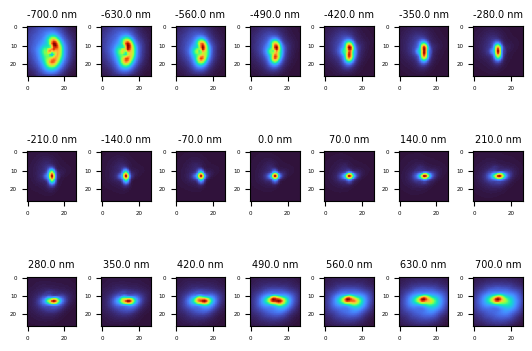

In [7]:
from utils.visual_utils import show_sample_psf

yaml_file_path = select_path('file')

print("File selected : ", yaml_file_path)

params= load_yaml_train(yaml_file_path)
print(show_confirming_string(namespace_to_dict(params)))

target_path = os.path.dirname(yaml_file_path)
os.chdir(target_path)
show_sample_psf(psf_pars=params.PSF_model)

### Displaying Simulated Images
The background value for simulated images is either provided from the parameters or calculated from the given test dataset. Below are examples of the dataset simulation process. 

In [8]:
if params.Training.bg is None:
    from network.loc_model import LocModel
    liteloc = LitelocModel(params)

The figures below exhibit 4 examples of the ground truth of the lateral locations of emitters, shown at the top. The simulated images are then synthesized based on the random selected emitter locations and the 3D PSF presented above.

E:\Torch\LiteLoc_0401\utils\data_generator.py:453: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:85.)
  blink_p = torch.cuda.FloatTensor(M)


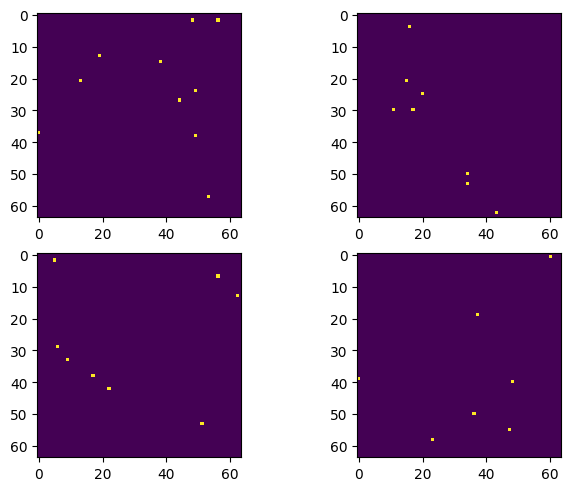

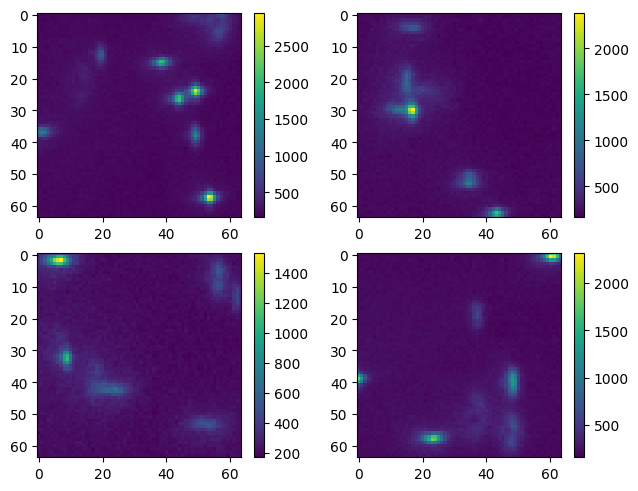

In [9]:
from utils.visual_utils import show_train_img
show_train_img(image_num=4, camera_params=params.Camera, psf_params=params.PSF_model, train_params=params.Training)

## Model Inference
Similar to the training process, parameter setting is the first step to apply the pre-trained model. As single molecule localization (**SMLM**) technology involves a temporal and spatial trade-off, the number of input image frames is typically large when implementing 3D localization and synthesizing 3D super-resolution images. Device settings play a key role in accelerating the inference process. To define your own parameters, use the following code, similar to the one provided above.

In [10]:
os.chdir(main_directory)
infer_params_dict = Infer_GUI()

print(show_confirming_string(infer_params_dict))

infer_params = dict_to_namespace(infer_params_dict)

yaml_file_folder = select_path('folder')

file_name = input()
if file_name[-5:] != '.yaml': 
    file_name += '.yaml'
    
yaml_file_path = os.path.join(yaml_file_folder, file_name)
save_yaml(params, yaml_file_path)

print("File saved as : {}".format(yaml_file_path))

--Loc_Model :
model_path : None
--Multi_Process :
image_path : None
save_path : None
time_block_gb : 1
batch_size : 30
over_cut : 8
multi_gpu : True
num_producers : 1



 0407infer


File saved as : E:/Torch/LiteLoc_0401\0407infer.yaml
